In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow.python.client import device_lib

config = tf.ConfigProto(allow_soft_placement=True, 
                        log_device_placement=True)
config.gpu_options.allow_growth = True
sess = tf.Session(config=config) 

tf.keras.backend.set_session(sess)

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

['/device:GPU:0']

## Analysis of the dataset

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

input_shape = x_train.shape[1:]
num_classes = np.unique(y_train).shape[0]

print("number of classes:", num_classes)
print("input shape:", input_shape)
print("Image data type:", x_train.dtype)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
number of classes: 10
input shape: (32, 32, 3)
Image data type: uint8


The dataset consists of 60000 images of size 32x32 pixels. The images are rgb (3 channels). There are 10 classes in the dataset.

### Visualisation of the dataset

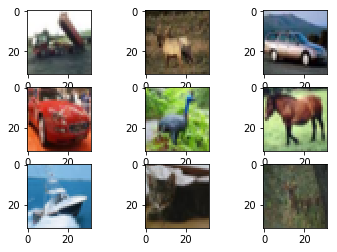

In [4]:
for row in range(3):
    for col in range(3):
        idx = row * 3 + col + 1
        plt.subplot(3,3, idx)
        plt.imshow(x_train[idx + 1])

(50000, 1)


<BarContainer object of 10 artists>

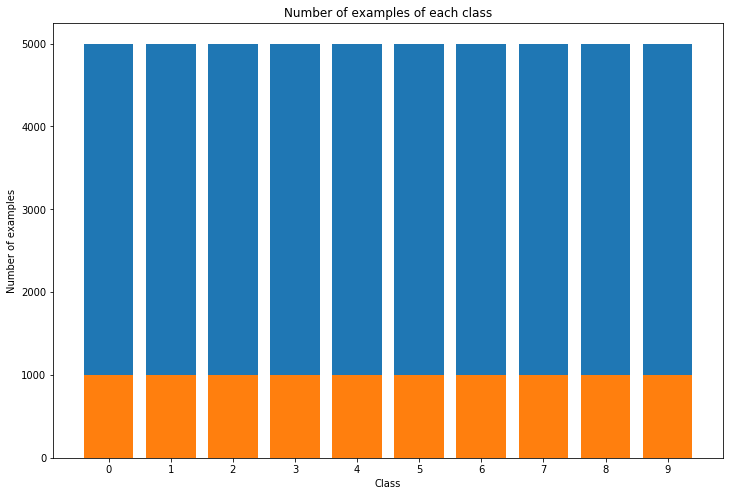

In [5]:
print(y_train.shape)
class_distribution_train = Counter(y_train[:,0])
class_distribution_test = Counter(y_test[:,0])
x = range(10)
train_y = [class_distribution_train[cls] for cls in x]
test_y = [class_distribution_test[cls] for cls in x]
plt.figure(figsize=(12,8))
plt.xticks(x)
plt.title("Number of examples of each class")
plt.xlabel("Class")
plt.ylabel("Number of examples")
plt.bar(x, train_y)
plt.bar(x, test_y)

The dataset is evenly distributed across the 10 classes.

### Normalize the dataset

In [6]:
x_train = x_train.astype('float16')
x_test = x_test.astype('float16')
x_train /= 255
x_test /= 255
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

### Split out validation data

In [74]:
train_val_split = 0.85 # Percentage of data to use in training set
indexes = np.arange(x_train.shape[0])
np.random.shuffle(indexes)
# Select random indexes for train/val set
idx_train = indexes[:int(train_val_split * x_train.shape[0])]
idx_val = indexes[int(train_val_split * x_train.shape[0]):]

x_val_data = x_train[idx_val]
y_val_data = y_train[idx_val]

x_train_data = x_train[idx_train]
y_train_data = y_train[idx_train]

print("Training images:", x_train_data.shape)
print("Validation images:", x_val_data.shape)
print("Test images:", x_test.shape)

Training images: (42500, 32, 32, 3)
Validation images: (7500, 32, 32, 3)
Test images: (10000, 32, 32, 3)


### Data augmentation

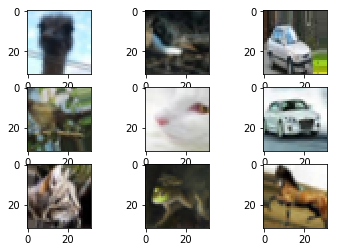

In [110]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train_data)

for x_batch, y_batch in datagen.flow(x_train_data,
                                     y_train_data,
                                     batch_size=9):
    for i in range(0, 9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(x_batch[i])
    plt.show()
    break

Data augmentation rotates, shifts and flips the images, and gives us more varied training data, thus preventing overfitting

## Known model

### Model definition

In [61]:
model1 = tf.keras.models.Sequential()
model1.add(tf.keras.layers.Conv2D(32, (3, 3), input_shape=input_shape))
model1.add(tf.keras.layers.Activation('relu'))
model1.add(tf.keras.layers.MaxPool2D())
model1.add(tf.keras.layers.Conv2D(64, (3, 3)))
model1.add(tf.keras.layers.Activation('relu'))
model1.add(tf.keras.layers.MaxPool2D())
model1.add(tf.keras.layers.Conv2D(128, (3, 3)))
model1.add(tf.keras.layers.Activation('relu'))
model1.add(tf.keras.layers.MaxPool2D())

model1.add(tf.keras.layers.Flatten())

model1.add(tf.keras.layers.Dense(128))
model1.add(tf.keras.layers.Activation('relu'))
model1.add(tf.keras.layers.Dense(64))
model1.add(tf.keras.layers.Activation('relu'))
model1.add(tf.keras.layers.Dense(num_classes))
model1.add(tf.keras.layers.Activation('softmax'))

### Training the model

In [89]:
batch_size = 64
epochs = 15

In [93]:
opt = 'adam'

model1.compile(loss='categorical_crossentropy',
               optimizer=opt,
               metrics=['accuracy'])

In [94]:
model1.fit(datagen.flow(x_train_data, y_train_data, batch_size=batch_size),
           batch_size=batch_size,
           epochs=epochs,
           validation_data=(x_val_data, y_val_data),
           shuffle=True)

Epoch 1/15
665/665 [==============================] - 16s 24ms/step - loss: 0.8857 - acc: 0.6907 - val_loss: 0.7395 - val_acc: 0.7421
Epoch 2/15
665/665 [==============================] - 14s 21ms/step - loss: 0.8648 - acc: 0.6966 - val_loss: 0.6375 - val_acc: 0.7776
Epoch 3/15
665/665 [==============================] - 14s 21ms/step - loss: 0.8400 - acc: 0.7043 - val_loss: 0.6914 - val_acc: 0.7567
Epoch 4/15
665/665 [==============================] - 14s 21ms/step - loss: 0.8293 - acc: 0.7102 - val_loss: 0.7033 - val_acc: 0.7552
Epoch 5/15
665/665 [==============================] - 14s 21ms/step - loss: 0.8065 - acc: 0.7187 - val_loss: 0.7015 - val_acc: 0.7581
Epoch 6/15
665/665 [==============================] - 14s 21ms/step - loss: 0.7988 - acc: 0.7198 - val_loss: 0.7467 - val_acc: 0.7460
Epoch 7/15
665/665 [==============================] - 14s 20ms/step - loss: 0.7828 - acc: 0.7257 - val_loss: 0.7694 - val_acc: 0.7361
Epoch 8/15
665/665 [==============================] - 14s 20ms

In [32]:
def evaluate_model(model):
    model.summary()
    # evaluate the model using the test data
    test_loss, test_acc = model.evaluate(x_test, y_test)
    print("Test loss: %.4f, accuracy: %.4f" % (test_loss, test_acc))

def visualize_loss_history(model):
    history = model.history.history
    plt.figure(figsize=(12, 8))
    plt.plot(history["val_loss"], label="Validation loss")
    plt.plot(history["loss"], label="Training loss")
    plt.legend()

def visualize_accuracy_history(model):
    history = model.history.history
    plt.figure(figsize=(12, 8))
    plt.plot(history["val_acc"], label="Validation accuracy")
    plt.plot(history["acc"], label="Training accuracy")
    plt.legend()

In [95]:
evaluate_model(model1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
activation_36 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
activation_37 (Activation)   (None, 13, 13, 64)        0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 4, 4, 128)         73856     
__________

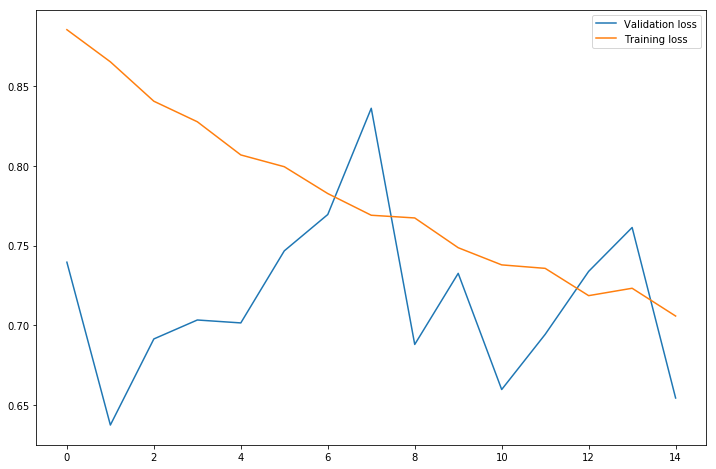

In [96]:
visualize_loss_history(model1)

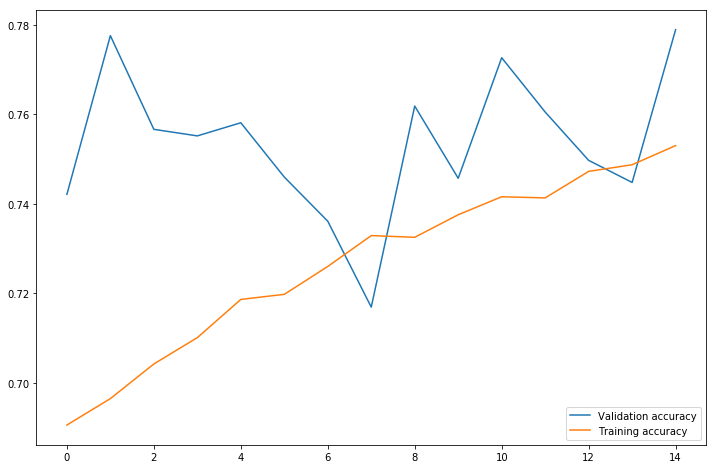

In [97]:
visualize_accuracy_history(model1)

### Model 3

In [111]:
model3 = tf.keras.models.Sequential()
model3.add(tf.keras.layers.Conv2D(32, (3, 3), input_shape=input_shape))
model3.add(tf.keras.layers.Activation('relu'))
model3.add(tf.keras.layers.BatchNormalization())
model3.add(tf.keras.layers.Conv2D(32, (3, 3)))
model3.add(tf.keras.layers.Activation('relu'))
model3.add(tf.keras.layers.Dropout(0.2))
model3.add(tf.keras.layers.MaxPool2D())

model3.add(tf.keras.layers.Conv2D(64, (3, 3)))
model3.add(tf.keras.layers.Activation('relu'))
model3.add(tf.keras.layers.BatchNormalization())
model3.add(tf.keras.layers.Conv2D(64, (3, 3)))
model3.add(tf.keras.layers.Activation('relu'))
model3.add(tf.keras.layers.Dropout(0.25))
model3.add(tf.keras.layers.BatchNormalization())

model3.add(tf.keras.layers.Conv2D(128, (3, 3)))
model3.add(tf.keras.layers.Activation('relu'))
model3.add(tf.keras.layers.Dropout(0.3))
model3.add(tf.keras.layers.Conv2D(128, (3, 3)))
model3.add(tf.keras.layers.Activation('relu'))
model3.add(tf.keras.layers.Dropout(0.2))
model3.add(tf.keras.layers.MaxPool2D())
           
model3.add(tf.keras.layers.Flatten())
model3.add(tf.keras.layers.Dense(256))
model3.add(tf.keras.layers.Activation('relu'))
model3.add(tf.keras.layers.Dropout(0.3))
model3.add(tf.keras.layers.Dense(128))
model3.add(tf.keras.layers.Activation('relu'))
model3.add(tf.keras.layers.Dropout(0.2))
model3.add(tf.keras.layers.Dense(64))
model3.add(tf.keras.layers.Activation('relu'))
model3.add(tf.keras.layers.Dense(num_classes))
model3.add(tf.keras.layers.Activation('softmax'))

In [112]:
opt = 'adam'

model3.compile(loss='categorical_crossentropy',
               optimizer=opt,
               metrics=['accuracy'])

In [ ]:
epochs = 400

model3.fit(datagen.flow(x_train_data, y_train_data, batch_size=batch_size),
           batch_size=batch_size,
           epochs=epochs,
           validation_data=(x_val_data, y_val_data),
           shuffle=True)

Epoch 1/400
665/665 [==============================] - 20s 29ms/step - loss: 1.7515 - acc: 0.3439 - val_loss: 1.7541 - val_acc: 0.3776
Epoch 2/400
665/665 [==============================] - 16s 24ms/step - loss: 1.3952 - acc: 0.5014 - val_loss: 1.6255 - val_acc: 0.4403
Epoch 3/400
665/665 [==============================] - 16s 24ms/step - loss: 1.2319 - acc: 0.5638 - val_loss: 1.1873 - val_acc: 0.5809
Epoch 4/400
665/665 [==============================] - 16s 24ms/step - loss: 1.1289 - acc: 0.6041 - val_loss: 1.2569 - val_acc: 0.5543
Epoch 5/400
665/665 [==============================] - 16s 24ms/step - loss: 1.0790 - acc: 0.6240 - val_loss: 1.0881 - val_acc: 0.6071
Epoch 6/400
665/665 [==============================] - 16s 24ms/step - loss: 1.0174 - acc: 0.6448 - val_loss: 0.9947 - val_acc: 0.6584
Epoch 7/400
665/665 [==============================] - 16s 24ms/step - loss: 0.9705 - acc: 0.6669 - val_loss: 0.8806 - val_acc: 0.6976
Epoch 8/400
665/665 [==============================] - 

In [102]:
evaluate_model(model3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
activation_64 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
activation_65 (Activation)   (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 14, 14, 32)        0         
__________

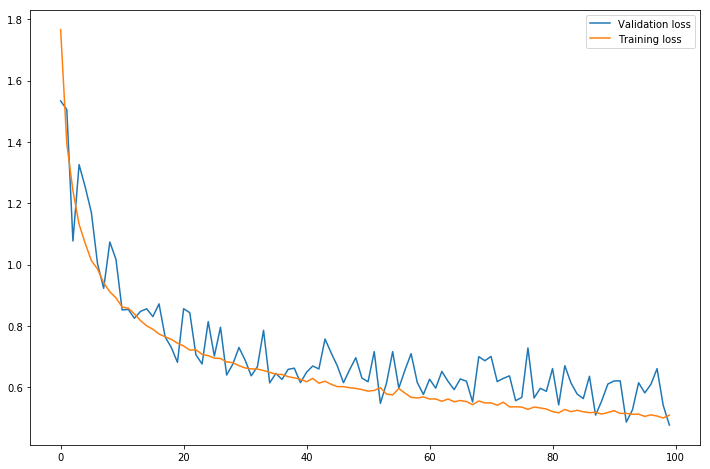

In [103]:
visualize_loss_history(model3)

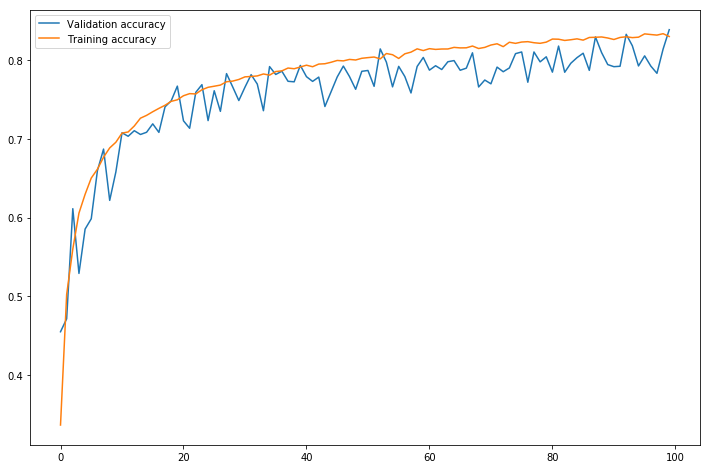

In [104]:
visualize_accuracy_history(model3)